In [1]:
import scipy
import random
import portpy.photon as pp
from skimage import measure
import numpy as np
from cvxpy import *
from scipy import sparse
import sklearn.metrics
import cProfile
import time
import sys
import psutil
import cvxpy as cp
from scipy.linalg import LinAlgError
import matplotlib.pyplot as plt

D:\ANACONDA\lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
data_dir = r'../data'
data = pp.DataExplorer(data_dir=data_dir)
patient_id = 'Lung_Phantom_Patient_1'
data.patient_id = patient_id
ct = pp.CT(data)
structs = pp.Structures(data)
beams = pp.Beams(data)
opt_params = data.load_config_opt_params(protocol_name='Lung_2Gy_30Fx')
structs.create_opt_structures(opt_params)
inf_matrix_sparse = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams)
protocol_name = 'Lung_2Gy_30Fx'
clinical_criteria = pp.ClinicalCriteria(data, protocol_name)
plan_sparse = pp.Plan(ct, structs, beams, inf_matrix_sparse, clinical_criteria)
opt = pp.Optimization(plan_sparse, opt_params=opt_params)
opt.create_cvxpy_problem()

sol_sparse = opt.solve(solver='MOSEK', verbose=True)
dose_sparse_1d = plan_sparse.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions())
x_sparse =sol_sparse['optimal_intensity'] * plan_sparse.get_num_of_fractions()

beams_full = pp.Beams(data, load_inf_matrix_full=True)
inf_matrix_full = pp.InfluenceMatrix(ct=ct, structs=structs, beams=beams_full, is_full=True)
plan_full = pp.Plan(ct, structs, beams, inf_matrix_full, clinical_criteria)
dose_full_1d = plan_full.inf_matrix.A @ (sol_sparse['optimal_intensity'] * plan_full.get_num_of_fractions())

A_dense = plan_full.inf_matrix.A
A_sparse = plan_sparse.inf_matrix.A


creating rinds.. This step may take some time due to dilation
rinds created!!
Creating BEV..
Loading sparse influence matrix...
Done
Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done
                                     CVXPY                                     
                                     v1.3.1                                    
(CVXPY) Aug 07 10:19:37 AM: Your problem has 1946 variables, 14 constraints, and 0 parameters.
(CVXPY) Aug 07 10:19:37 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Aug 07 10:19:37 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Aug 07 10:19:37 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation       

(CVXPY) Aug 07 10:19:44 AM: 21  3.3e-07  1.1e-06  3.1e-11  1.00e+00   4.204653231e+01   4.204653206e+01   2.3e-09  3.11  
(CVXPY) Aug 07 10:19:44 AM: 22  9.5e-08  3.1e-07  4.8e-12  9.56e-01   4.204568395e+01   4.204568387e+01   6.6e-10  3.20  
(CVXPY) Aug 07 10:19:44 AM: 23  7.2e-08  7.8e-08  6.2e-13  1.01e+00   4.204544808e+01   4.204544806e+01   1.7e-10  3.28  
(CVXPY) Aug 07 10:19:44 AM: Optimizer terminated. Time: 3.39    
(CVXPY) Aug 07 10:19:44 AM: 
(CVXPY) Aug 07 10:19:44 AM: 
(CVXPY) Aug 07 10:19:44 AM: Interior-point solution summary
(CVXPY) Aug 07 10:19:44 AM:   Problem status  : PRIMAL_AND_DUAL_FEASIBLE
(CVXPY) Aug 07 10:19:44 AM:   Solution status : OPTIMAL
(CVXPY) Aug 07 10:19:44 AM:   Primal.  obj: 4.2045448085e+01    nrm: 1e+02    Viol.  con: 6e-06    var: 2e-06    cones: 0e+00  
(CVXPY) Aug 07 10:19:44 AM:   Dual.    obj: 4.2045448063e+01    nrm: 6e+03    Viol.  con: 0e+00    var: 8e-07    cones: 0e+00  
------------------------------------------------------------------

In [5]:
import numpy as np
import time



def importance_sampling(A_dense, c):
    m, n = A_dense.shape
    B = np.zeros((m, c))
    
    # Calculate the Probability p for each Column
    p = np.sum(A_dense, axis=0) / np.sum(A_dense)
    
    for j in range(c):
        # Select column i with probability p_i
        i = np.random.choice(n, p=p)
       # Add and scale the selected column
        B[:, j] = A_dense[:, i] / (c * p[i])
    
    return B

# HyperParameter
c = 400


start_time = time.time()
result = importance_sampling(A_dense, c)
end_time = time.time()


print(result)
total_execution_time = end_time - start_time
print(f" Matrix Build Runtime : {total_execution_time} Second")


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
 Matrix Build Runtime : 0.5914173126220703 Second


In [24]:
import pandas as pd

df_S = pd.DataFrame(result.T)
df_S

,0,1,2,3,4,5,6,7,8,9,...,60173,60174,60175,60176,60177,60178,60179,60180,60181,60182
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
df_A = pd.DataFrame(A_dense)
df_A

,0,1,2,3,4,5,6,7,8,9,...,532,533,534,535,536,537,538,539,540,541
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60178,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60179,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60180,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
60181,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
df_dose = pd.DataFrame(p)
df_dose

,0
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0
...,...
60178,0.0
60179,0.0
60180,0.0
60181,0.0


In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60183 entries, 0 to 60182
Columns: 400 entries, 0 to 399
dtypes: float64(400)
memory usage: 183.7 MB


In [28]:
df.describe()

,0,1,2,3,4,5,6,7,8,9,...,390,391,392,393,394,395,396,397,398,399
count,60183.000000,60183.000000,60183.000000,60183.000000,60183.000000,60183.000000,60183.000000,60183.000000,60183.000000,60183.000000,...,60183.000000,60183.000000,60183.000000,60183.000000,60183.000000,60183.000000,60183.000000,60183.000000,60183.000000,60183.000000
mean,0.002108,0.002108,0.002108,0.002108,0.002108,0.002108,0.002108,0.002108,0.002108,0.002108,...,0.002108,0.002108,0.002108,0.002108,0.002108,0.002108,0.002108,0.002108,0.002108,0.002108
std,0.031521,0.026397,0.027944,0.032123,0.027051,0.027731,0.033742,0.030765,0.033461,0.035820,...,0.030871,0.027051,0.024810,0.028060,0.026968,0.032895,0.032222,0.031794,0.035408,0.033780
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000476,0.000314,0.000132,0.000418,0.000424,0.000000,0.000416,0.000000,0.000000,...,0.000166,0.000418,0.000351,0.000316,0.000413,0.000000,0.000129,0.000000,0.000000,0.000228
max,1.852003,0.975830,1.646540,2.083910,1.050084,1.174490,2.431698,1.512187,1.790124,2.211251,...,1.788326,1.050084,0.961624,1.672330,1.036271,2.000096,1.923814,1.711168,2.316141,2.101465


In [29]:
S = result.T
A = A_dense
p = dose_full_1d
print(f'S = {S.shape}\nA = {A.shape}\np = {p.shape}')

S = (400, 60183)
A = (60183, 542)
p = (60183,)


In [31]:
start_time = time.time()

sol_ls_S = scipy.sparse.linalg.lsqr(S @ A, S @ p )
    
end_time = time.time()
total_execution_time = end_time - start_time
print(f"LS solution time{total_execution_time} Second")



LS solution time2.7350051403045654 Second


In [32]:
x_sampling = sol_ls_S[0]
cost = sum_squares(S @ A @ x_sampling - S @ p)
prob = Problem(Minimize(cost))
sol = prob.solve(solver='MOSEK', verbose=False)
sol

0.19872640284193493

<br><center> ***Minimize*** $\lVert SAx - Sp\rVert_{2}^2$

  

In [33]:
opt = pp.Optimization(plan_full, opt_params=opt_params)
opt.create_cvxpy_problem()

sol_dense = opt.solve(solver='MOSEK', verbose=False)

x_dense = sol_dense['optimal_intensity'] * plan_full.get_num_of_fractions()

Objective Start
Objective done
Constraints Start
Structure ESOPHAGUS not available!
Structure ESOPHAGUS not available!
Constraints done


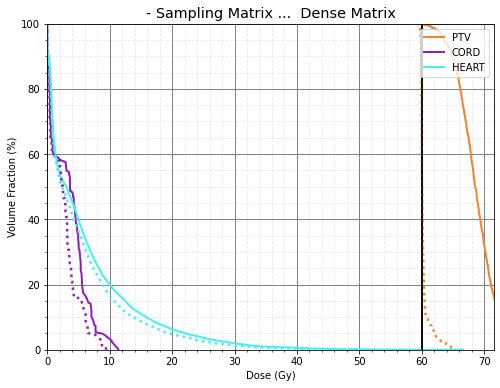

Done!


In [34]:
# DVH Plot
dose_dense = plan_full.inf_matrix.A @ x_dense
dose_sampling = plan_full.inf_matrix.A @ x_sampling 

fig, ax = plt.subplots(figsize=(8, 6))
struct_names = ['PTV', 'ESOPHAGUS', 'HEART', 'CORD']
ax = pp.Visualization.plot_dvh(plan_full, dose_1d= dose_sampling, struct_names=struct_names, style='solid', ax=ax)
ax = pp.Visualization.plot_dvh(plan_full, dose_1d=dose_dense, struct_names=struct_names, style='dotted', ax=ax)
ax.set_title('- Sampling Matrix ...  Dense Matrix')
plt.savefig('DVH_Sampling.png')
plt.show()
print('Done!')

In [35]:
print("Data Type:", dose_sampling.dtype)

print("Shape:", dose_sampling.shape)


Data Type: float64
Shape: (60183,)


In [36]:
import pandas as pd

# Convert ndarray to DataFrame
dose_sampling_df = pd.DataFrame(dose_sampling)

# Describe
description = dose_sampling_df.describe()

print(description)


                  0
count  60183.000000
mean       6.484448
std       12.133363
min       -0.032600
25%        0.343266
50%        1.350590
75%        6.418513
max       80.572016


In [38]:
##  Analysis of matrix sparsity

is_sparse = sparse.issparse(S)
is_sparse

False

In [39]:
x_sampling = sol_ls_S[0]
print(f'x :\t {x_sampling[0:6]}')

x :	 [ 3.49376337  2.79492847  2.53088764 -0.84849971  6.88901477 11.34606107]


In [40]:
sol_ls_A_Dense = scipy.sparse.linalg.lsqr(A_dense,dose_sparse_1d)
x_A_dense = sol_ls_A_Dense[0]

relative_error = np.linalg.norm(x_A_dense - x_sampling) / np.linalg.norm(x_A_dense)
print(f'relative_error:', relative_error)


relative_error: 0.32854916876579954


In [56]:
x_A_dense= sol_ls_A_Dense[0]
print(f'x_A_dense :\t {x_A_dense[0:6]}')

cost = cp.sum_squares((A_dense @ x_A_dense  - A_dense @ x_sampling  )/ cp.norm(A_dense @ x_A_dense))
prob = cp.Problem(Minimize(cost))
sol = prob.solve(solver='MOSEK', verbose=False)
sol

x_A_dense :	 [ 3.67488292 -1.8787623  -1.95529727 -2.43993656 12.0689664   5.92366068]


0.052129762126147006

In [41]:
# Norm Frobenius

cost = cp.norm(A_dense @ x_A_dense - A_dense @ x_sampling, "fro")/ cp.norm(A_dense @ x_A_dense, "fro")

prob = cp.Problem(cp.Minimize(cost))

prob.solve()


0.22831943002326152

In [69]:
nonzero_count = np.count_nonzero(A_dense)
print("nnz A Matrix: ", nonzero_count)
num_non_zero = np.count_nonzero(S @ A)
print("nnz SA Matrix :", num_non_zero)
nnz_S = np.count_nonzero(S )
print("nnz S Matrix :", nnz_S)

nnz A Matrix:  10279072
nnz SA Matrix : 216800
nnz S Matrix : 7868388


In [80]:
m,n = A_dense.shape

In [79]:
# nnz
m,n = A_dense.shape

num_non_zero_elements_dense = np.count_nonzero(S)/ (c * m)
print("S nnz:", num_non_zero_elements_dense)

num_non_zero_elements_dense = np.count_nonzero(S @ A_dense)/ (c * n)
print("SA nnz:", num_non_zero_elements_dense)

num_non_zero_elements_A_dense = np.count_nonzero(A_dense)/ (m *  n)
print("A nnz:", num_non_zero_elements_A_dense)


S nnz: 0.3268525995713075
SA nnz: 1.0
A nnz: 0.3151234981768092


In [43]:
cost = cp.sum_squares((p  - A_dense @ x_sampling  )/ cp.norm(p))
prob = cp.Problem(Minimize(cost))
prob.solve()

0.021967554065786533

In [63]:
## MSE 

d_true = p          # Real Dose 
d_pred = A_dense @ x_sampling   # Predicted Dose  

MSE1 = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE1)


Mean Squared Error : 4.207623889765747


In [64]:
## MSE 

d_true = A_dense @ x_A_dense            # Real Dose 
d_pred = A_dense @ x_sampling   # Predicted Dose  

MSE2 = np.mean((d_true - d_pred) ** 2)
print("Mean Squared Error :", MSE2)
 

Mean Squared Error : 7.374259135465143


In [50]:
r1 = np.linalg.matrix_rank(S @ A_dense) 
r2 = np.linalg.matrix_rank(A_dense)      
print( f'Rank approximation matrix = {r1}\n Rank  Dense matrix = {r2}')

Rank approximation matrix = 279
 Rank  Dense matrix = 542


In [66]:
memory_usage_sol_ls_S = sys.getsizeof(sol_ls_S )
megabyte_size_sol_ls_S = memory_usage_sol_ls_S / 1024 / 1024

print(f"Memory sol_ls_S:  {megabyte_size_sol_ls_S} MB")

Memory sol_ls_S:  0.00011444091796875 MB


In [65]:
memory_usage_S = sys.getsizeof(S)
megabyte_size_S = memory_usage_S / 1024 / 1024

print(f"Memory S : {megabyte_size_S} MB")

Memory S : 0.0001220703125 MB


In [53]:
import numpy as np

def calculate_relative_error(vector1, vector2):
   
    array1 = np.array(x_A_dense)
    array2 = np.array(x_sampling)

    norm_vector2 = np.linalg.norm(x_A_dense)

    relative_error = np.linalg.norm(x_A_dense - x_sampling) / norm_vector2

    return relative_error

error = calculate_relative_error(x_A_dense, x_sampling)
print(f"Relative Error: {error}")


Relative Error: 0.49343725501977476


In [54]:
import numpy as np

def calculate_absolute_error(vector1, vector2):
    array1 = np.array(x_A_dense)
    array2 = np.array(x_sampling)

    absolute_error = np.linalg.norm(array1 - array2, ord=1) 

    return absolute_error


error = calculate_absolute_error(x_A_dense, x_sampling)
print(f"Absolute Error: {error}")


Absolute Error: 1444.1983175016287
